In [1]:
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
from skimage.morphology import skeletonize
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)
from scipy.interpolate import griddata
from PIL import Image
import pandas as pd
from scipy.optimize import curve_fit
plt.style.use('presentation.mplstyle')
from scipy.interpolate import interp1d
import scipy.optimize as opt


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [199]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def Gaussian2d(x,y, sigma, x0,y0,n=1):    
    return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))
def twoD_Gaussian(xy, sigma,amp, x0, y0):
    x, y = xy
    g = amp*(np.exp(-(((x-x0)**2 + (y-y0)**2) / (2*sigma**2))**n))
    return g.ravel()
def twoD_Gaussian_assym(xy, amplitude, xo, yo, sigma_x, sigma_y, offset,n=1):
    theta = 0
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = 1/sigma_x**2
    # b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    
    c = 1/sigma_y**2
    g = offset + amplitude*np.exp( -(1/2*(a*((x-xo)**2)
                            + c*((y-yo)**2)))**n)
    return g.ravel()

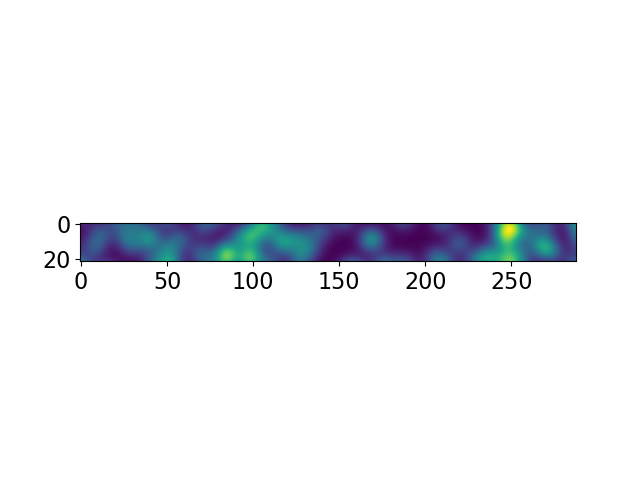

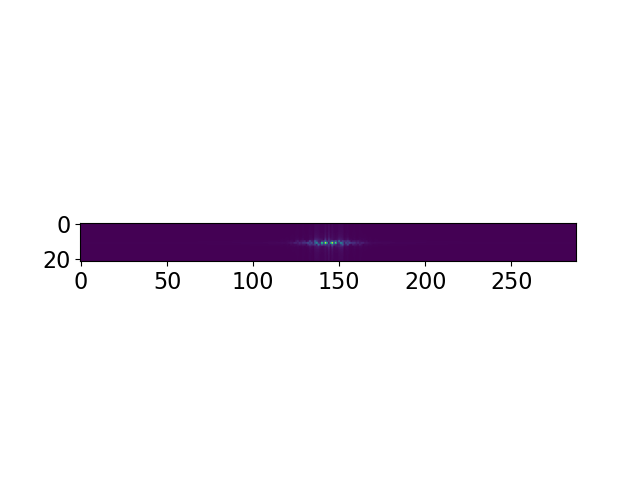

In [231]:
# Nx= 250
# Ny = 440

# maxix = 250
# maxiy= 440
Nx = image.shape[1]
Ny = image.shape[0]
maxix = Nx*space_pixel_size
maxiy = Ny*space_pixel_size
x = np.linspace(0,maxix,Nx)
y = np.linspace(0,maxiy,Ny)
x,y = np.meshgrid(x,y)
x0 = maxix//2
y0 = maxiy//2
sigma = 0.7
fig,ax = plt.subplots()
k = 200
n= 6
x0s = np.random.random(k)*2*maxix-maxix//2
y0s = np.random.random(k)*2*maxiy-maxiy//2
image = np.sum([Gaussian2d(x,y,sigma,x0,y0,n=n) for (x0,y0) in zip(x0s,y0s)],axis=0)/k
noise = np.random.normal(0,0.00005,(Ny,Nx))
# noise = 0
ax.imshow(image+noise)
ZMUV_image= (image-np.mean(image))/np.std(image)
# ZMUV_image=image
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(ZMUV_image))
fig,ax = plt.subplots()
ax.imshow(abs(dark_image_grey_fourier))
autocorrelation = np.fft.ifftshift(np.fft.ifft2(abs(dark_image_grey_fourier)))
# fig,ax = plt.subplots()
# ax.imshow(np.log(abs(autocorrelation)))

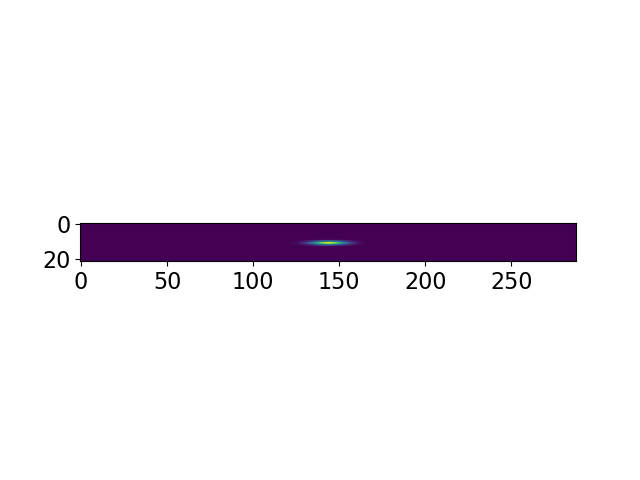

In [232]:
amplitude = np.max(abs(dark_image_grey_fourier))
dark_image_grey_fourier[dark_image_grey_fourier.shape[0]//2,dark_image_grey_fourier.shape[1]//2]=amplitude
initial_guess = (amplitude,maxix/2,maxiy/2,1,1,10)
popt2, pcov = opt.curve_fit(twoD_Gaussian_assym, (x, y), abs(dark_image_grey_fourier).ravel(), p0=initial_guess)
fig, ax = plt.subplots()
data_fitted = twoD_Gaussian_assym((x, y), *popt2)
ax.imshow(data_fitted.reshape(Ny, Nx))

plt.show()

In [233]:
xsigma,ysigma=1/(2*popt2[3]*np.pi)*maxix**2/Nx,1/(2*popt2[4]*np.pi)*maxiy**2/Ny

In [234]:
np.sqrt(xsigma*ysigma),xsigma,ysigma

(0.7381653197805921, 0.8511821885941134, 0.6401544189109128)

C:\Users\coren\AppData\Local\Temp\ipykernel_4080\1513098953.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,images[500]))


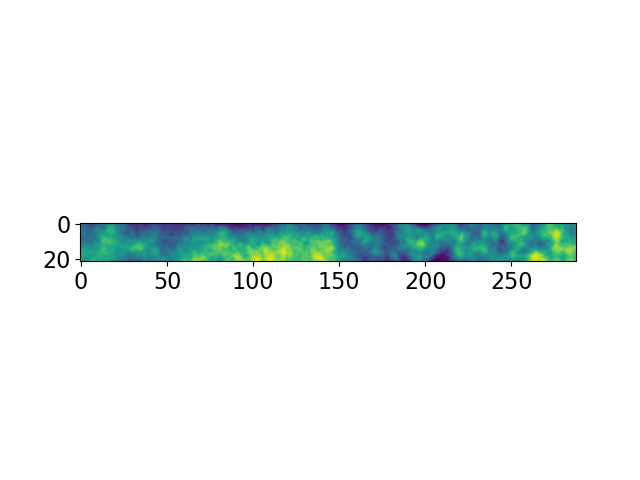

In [116]:
images_path = 'spatial_frequ'
images = os.listdir(images_path)
image = imageio.imread(os.path.join(images_path,images[500]))
binning = 2
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning #um.pixel
fig,ax =plt.subplots()
squared = image

ax.imshow(squared)

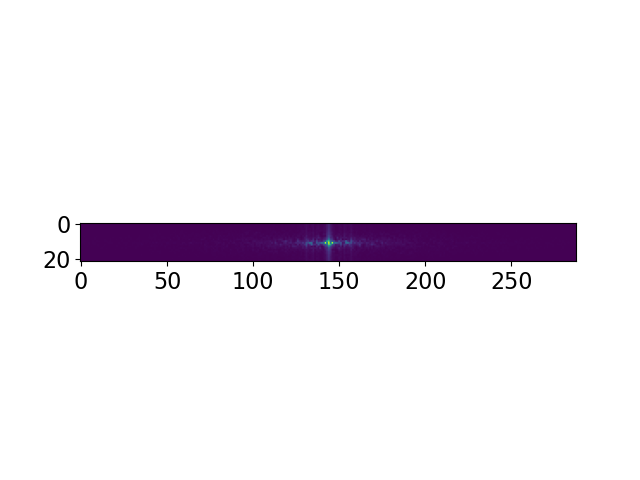

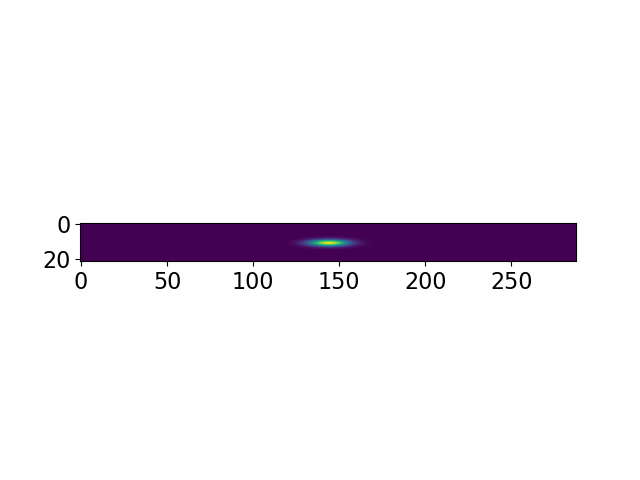

In [75]:


Nx = image.shape[1]
Ny = image.shape[0]
maxix = Nx*space_pixel_size
maxiy = Ny*space_pixel_size

x = np.linspace(0,maxix,Nx)
y = np.linspace(0,maxiy,Ny)
x,y = np.meshgrid(x,y)
ZMUV_image= (squared-np.mean(squared))/np.std(squared)
# ZMUV_image=image
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(ZMUV_image))


autocorrelation = np.fft.ifftshift(np.fft.ifft2(abs(dark_image_grey_fourier)))
# fig,ax = plt.subplots()
# ax.imshow(np.log(abs(autocorrelation)))
amplitude = np.max(abs(dark_image_grey_fourier))
dark_image_grey_fourier[dark_image_grey_fourier.shape[0]//2,dark_image_grey_fourier.shape[1]//2]=amplitude
fig,ax = plt.subplots()
ax.imshow(abs(dark_image_grey_fourier))
initial_guess = (amplitude,space_pixel_size * Nx/2,space_pixel_size*Ny/2,1,1,10)
popt2, pcov = opt.curve_fit(twoD_Gaussian_assym, (x, y), abs(dark_image_grey_fourier).ravel(), p0=initial_guess)
fig, ax = plt.subplots()
data_fitted = twoD_Gaussian_assym((x, y), *popt2)
#ax.hold(True) For older versions. This has now been deprecated and later removed
# ax.imshow(abs(dark_image_grey_fourier), cmap=plt.cm.jet, origin='lower',
#     extent=(x.min(), x.max(), y.min(), y.max()))
# ax.contour(x, y, data_fitted.reshape(N, N), 8, colors='w')
ax.imshow(data_fitted.reshape(Ny, Nx))



In [76]:
1/(2*popt2[3]*np.pi)*maxix**2/Nx,1/(2*popt2[4]*np.pi)*maxiy**2/Ny

(0.7786990136719796, 0.3588307686421769)

In [136]:
len(images[::20])

31

In [82]:
image = imageio.imread(os.path.join(images_path,images[500]))
sigmax = []
sigmay = []
for path in images[::20]:
    image = imageio.imread(os.path.join(images_path,path))
    squared = image
    Nx = image.shape[1]
    Ny = image.shape[0]
    maxix = Nx*space_pixel_size
    maxiy = Ny*space_pixel_size

    x = np.linspace(0,maxix,Nx)
    y = np.linspace(0,maxiy,Ny)
    x,y = np.meshgrid(x,y)
    ZMUV_image= (squared-np.mean(squared))/np.std(squared)
    # ZMUV_image=image
    dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(ZMUV_image))


    autocorrelation = np.fft.ifftshift(np.fft.ifft2(abs(dark_image_grey_fourier)))
    # fig,ax = plt.subplots()
    # ax.imshow(np.log(abs(autocorrelation)))
    amplitude = np.max(abs(dark_image_grey_fourier))
    initial_guess = (amplitude,space_pixel_size * Nx/2,space_pixel_size*Ny/2,1,1,10)
    popt2, pcov = opt.curve_fit(twoD_Gaussian_assym, (x, y), abs(dark_image_grey_fourier).ravel(), p0=initial_guess)
    sigmax.append(1/(2*popt2[3]*np.pi)*maxix**2/Nx)
    sigmay.append(1/(2*popt2[4]*np.pi)*maxiy**2/Ny)
    


C:\Users\coren\AppData\Local\Temp\ipykernel_4080\1198928353.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,images[500]))
C:\Users\coren\AppData\Local\Temp\ipykernel_4080\1198928353.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,path))


In [163]:
np.median(sigmay),np.median(sigmax),np.median(np.sqrt(np.array(sigmax)*np.array(sigmay)))

(0.5053065063967735, 1.045747046880109, 0.7427203217330492)

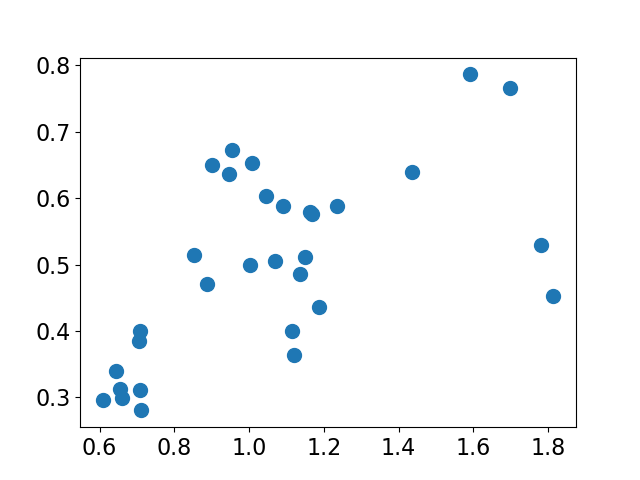

In [85]:
fig,ax = plt.subplots()
ax.scatter(sigmax,sigmay)